In [ ]:
# References
# https://www.kaggle.com/sibmike/fast-clear-wrmsse-18ms


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from joblib import Parallel, delayed

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submissionlogprice/submission_logprice_july20.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/competition/competition.csv
/kaggle/input/subcompete/submission_Finalcompete.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sales_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
price_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

sales_data = reduce_mem_usage(sales_data)
calendar = reduce_mem_usage(calendar)
price_data = reduce_mem_usage(price_data)

Mem. usage decreased to 96.13 Mb (78.8% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [4]:
submission_C = pd.read_csv('../input/competition/competition.csv')
submission_C = submission_C[submission_C.id.str.endswith('validation')]

submission_L = pd.read_csv('../input/submissionlogprice/submission_logprice_july20.csv')
submission_L = submission_L[submission_L.id.str.endswith('validation')]

NUM_ITEMS = sales_data.shape[0]    # 30490
DAYS_PRED = submission_C.shape[1] - 1    # 28

DAYS_PRED

28

In [5]:
submission_C.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.354023,0.532004,0.660989,0.834338,1.022468,0.900468,0.979321,0.941760,0.558008,...,0.383539,0.726482,0.435496,0.348077,0.432184,0.305310,0.213739,0.361059,0.716343,0.438079
1,HOBBIES_1_002_CA_1_validation,0.000000,0.000000,0.014295,0.681113,0.113240,0.123072,0.687077,0.056482,0.050713,...,0.479727,0.496649,0.441613,0.384855,0.372497,0.419928,0.495630,0.498090,0.497672,0.426658
2,HOBBIES_1_003_CA_1_validation,0.870345,0.677046,0.661009,0.397121,0.474550,1.424596,0.534979,0.383280,1.105223,...,0.905568,1.162062,0.991222,0.876820,0.900032,0.926215,0.927836,1.041338,1.291220,1.111686
3,HOBBIES_1_004_CA_1_validation,1.275865,0.536841,0.901037,2.930999,1.077676,2.734699,5.362715,0.886643,0.722521,...,1.787384,3.057006,4.049988,1.664256,1.096795,1.288123,1.660831,1.894668,3.143897,4.113658
4,HOBBIES_1_005_CA_1_validation,0.611603,0.560539,0.678535,1.047145,1.122657,0.767880,1.504652,0.818410,0.031997,...,0.499520,1.054556,1.045537,0.308350,0.449983,0.299664,0.483465,0.519334,1.104426,1.123129


In [6]:


def transform(df):
    newdf = df.melt(id_vars=["id"], var_name="d", value_name="sale")
    newdf.sort_values(by=['id', "d"], inplace=True)
    newdf.reset_index(inplace=True)
    return newdf

from sklearn.metrics import mean_squared_error

def rmse(gt,df):
    gt = transform(gt)
    df = transform(df)
    return np.sqrt(mean_squared_error( gt["sale"],df["sale"]))

## Compute RMSE

In [7]:
start_date = 1914 
dayCols = ["d_{}".format(i) for i in range(start_date, start_date+DAYS_PRED)]

gt  = sales_data[["id"]+dayCols]
gt.shape
rmse(gt,submission_C)

start_date = 1914 
dayCols = ["d_{}".format(i) for i in range(start_date, start_date+DAYS_PRED)]

gt  = sales_data[["id"]+dayCols]
gt.shape
rmse(gt,submission_L)

2.493631833229017

In [8]:
gt['id2'] = gt['id'].str.replace('evaluation','')
submission_C['id2'] = submission_C['id'].str.replace('validation','')
submission_L['id2'] = submission_L['id'].str.replace('validation','')

gt = gt[['id','id2'] + dayCols]
FCols = ['F' + str(i) for i in range(1,29)]
submission_C = submission_C[['id','id2'] + FCols]
submission_L = submission_L[['id','id2'] + FCols]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
def rmse2(submission,i):
    SE_col =[]
    for j in range(2,submission.shape[1]):
        y = float(gt.iloc[i,j])
        yhat = float(submission.iloc[i,j])
        #print(y,yhat)
        e_i = (y-yhat)**2
        SE_col.append(e_i)
    #print(len(SE_col))
    #print(gt.iloc[i,0])
    return np.sqrt(sum(SE_col)/len(SE_col))

    

In [11]:
RMSE_id_C = Parallel(n_jobs=4, backend="multiprocessing")(delayed(rmse2)(submission_C,i) for i in  range(0,submission_C.shape[0]))
np.mean(RMSE_id_C)

1.473483652656262

In [12]:
len(RMSE_id_C)


30490

In [13]:
RMSE_id_L = Parallel(n_jobs=4, backend="multiprocessing")(delayed(rmse2)(submission_L,i) for i in  range(0,submission_L.shape[0]))
np.mean(RMSE_id_L)

1.4682874431354451

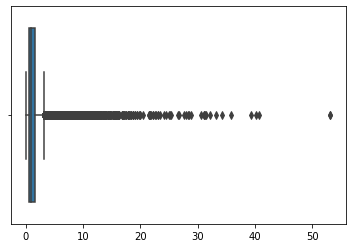

In [16]:
import seaborn as sns
sns.boxplot(RMSE_id_C)

In [17]:
df_RMSE = pd.DataFrame()
df_RMSE['RMSE_Model1']  = np.array(RMSE_id_C)
df_RMSE['RMSE_Model2']  = np.array(RMSE_id_L)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'RMSE - Sequence- Model 1 and Model2')

<Figure size 360x360 with 0 Axes>

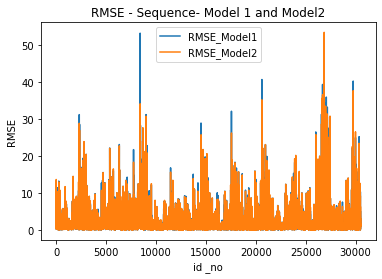

In [18]:
import matplotlib.pyplot as plt
log_RMSE_id_C = [np.log(i) for i in RMSE_id_C]
plt.figure(figsize = (5,5))
df_RMSE.plot()
plt.xlabel('id _no')
plt.ylabel('RMSE')
plt.title('RMSE - Sequence- Model 1 and Model2')



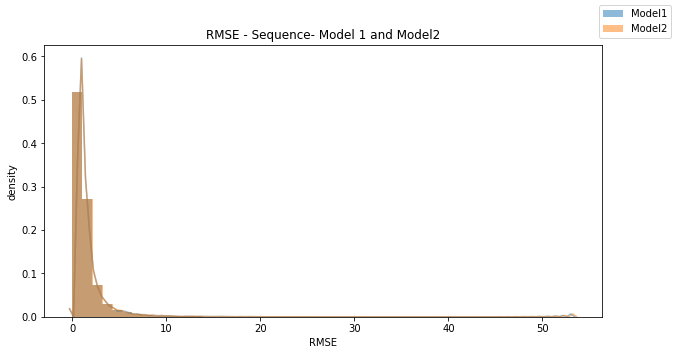

N_ items Model 1 30490 N_ items Model 2 30490


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
lst1 = list(df_RMSE['RMSE_Model1'])
lst2 = list(df_RMSE['RMSE_Model2'])
sns.distplot(lst1,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
sns.distplot(lst2,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
fig.legend(labels=['Model1','Model2'])
plt.xlabel('RMSE')
plt.ylabel('density')
plt.title('RMSE - Sequence- Model 1 and Model2')
plt.show()
print('N_ items Model 1',df_RMSE['RMSE_Model1'].shape[0],'N_ items Model 2',df_RMSE['RMSE_Model2'].shape[0])

In [20]:
df_RMSE.shape

(30490, 2)

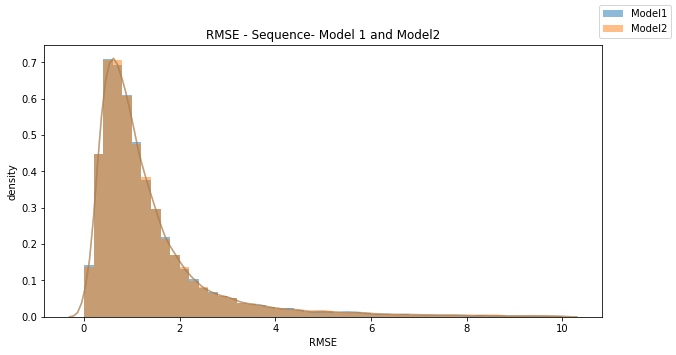

N_ items Model 1 30238 N_ items Model 2 30247


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
lst1 = list(df_RMSE[df_RMSE['RMSE_Model1']<10]['RMSE_Model1'])
lst2 = list(df_RMSE[df_RMSE['RMSE_Model2']<10]['RMSE_Model2'])
sns.distplot(lst1,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
sns.distplot(lst2,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
fig.legend(labels=['Model1','Model2'])
plt.xlabel('RMSE')
plt.ylabel('density')
plt.title('RMSE - Sequence- Model 1 and Model2')
plt.show()
print('N_ items Model 1',df_RMSE[df_RMSE['RMSE_Model1']<10]['RMSE_Model1'].shape[0],'N_ items Model 2',df_RMSE[df_RMSE['RMSE_Model2']<10]['RMSE_Model2'].shape[0])

## Compute RMSSE

In [24]:
def comp_rmsse(submission,counter):
    sales_data.head()
    train_column = sales_data.iloc[:,6:1919].columns.tolist()
    dif1 = []
    for i in range(6,1919):
        if i>6:
            temp = (sales_data.iloc[counter,i]  - sales_data.iloc[counter,i-1])**2
            dif1.append(temp)
    den = np.sqrt(sum(dif1)/(len(dif1)-1))
    #print(len(dif1))
    num = rmse2(submission,counter)
    rmsse = num/den
    return rmsse

In [25]:
RMSSE_C = Parallel(n_jobs=4, backend="multiprocessing")(delayed(comp_rmsse)(submission_C,i) for i in  range(0,sales_data.shape[0]))
np.mean(RMSSE_C)


0.9680660216327027

In [37]:
RMSSE_C[25]

2.4518947656737273

In [27]:
RMSSE_L = Parallel(n_jobs=4, backend="multiprocessing")(delayed(comp_rmsse)(submission_L,i) for i in  range(0,sales_data.shape[0]))
np.mean(RMSSE_L)


0.9658293302258028

In [28]:
RMSSE = pd.DataFrame()
RMSSE['RMSSE_Model1']  = np.array(RMSSE_C)
RMSSE['RMSSE_Model2']  = np.array(RMSSE_L)

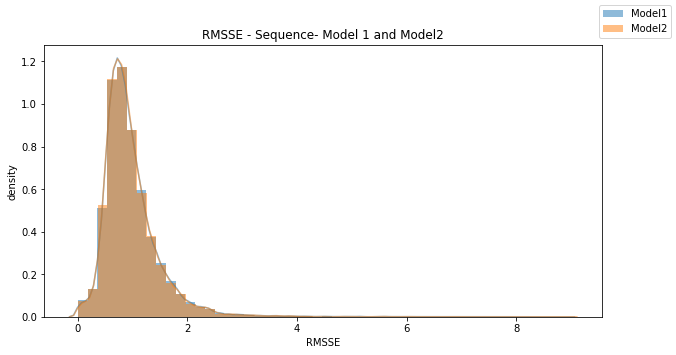

N_ items Model 1 30490 N_ items Model 2 30490


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
lst1 = list(RMSSE.loc[RMSSE['RMSSE_Model1']<10]['RMSSE_Model1'])
lst2 = list(RMSSE.loc[RMSSE['RMSSE_Model1']<10]['RMSSE_Model2'])
sns.distplot(lst1,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
sns.distplot(lst2,kde_kws={"alpha":0.5},hist_kws={"alpha":0.5})
fig.legend(labels=['Model1','Model2'])
plt.xlabel('RMSSE')
plt.ylabel('density')
plt.title('RMSSE - Sequence- Model 1 and Model2')
plt.show()
print('N_ items Model 1',RMSSE['RMSSE_Model1'].shape[0],'N_ items Model 2',RMSSE['RMSSE_Model2'].shape[0])